In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import files
# import io
# import glob


In [134]:
# df_main_ar = [pd.read_csv(io.BytesIO(uploaded[d])) for d in uploaded]
# path = r'./data' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = {}
# li = []
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     name = filename.split("/")[2][7:-4]
#     # li[name] = (df)
#     li.append(df)

AddressCount = pd.read_csv("./data/export-AddressCount.csv", index_col=None, header=0)
DAU = pd.read_csv("./data/export-DailyActiveEthAddress.csv", index_col=None, header=0)
MarCap = pd.read_csv("./data/export-MarketCap.csv", index_col=None, header=0)
NetHash = pd.read_csv("./data/export-NetworkHash.csv", index_col=None, header=0)
DailyTx = pd.read_csv("./data/export-TxGrowth.csv", index_col=None, header=0)
Fees = pd.read_csv("./data/export-TransactionFee.csv", index_col=None, header=0)
AVGFee = pd.read_csv("./data/export-AverageDailyTransactionFee.csv", index_col=None, header=0)

AddressCount = AddressCount.rename(columns={"Value":"AddressCount"})
NetHash = NetHash.rename(columns={"Value":"NetHash"})
DailyTx = DailyTx.rename(columns={"Value":"DailyTx"})
Fees = Fees.rename(columns={"Value":"Fees"})

DAU.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('UnixTimeStamp',axis = 1, inplace = True)
AVGFee.drop('DateTime',axis = 1, inplace = True)

frame = pd.concat([AddressCount, DAU,MarCap, NetHash, DailyTx, AVGFee], axis=1)
# frame.rename(columns={frame.columns[3]:'Drop'}, inplace=True)
frame = frame.T.drop_duplicates().T

frame['Date(UTC)'] = frame['Date(UTC)'].apply(pd.to_datetime)
frame['newAddressCount'] = frame['AddressCount'].diff()

# frame.drop('Drop',axis = 1, inplace = True)
frame = frame[1500:]
# frame = pd.concat(li, axis=1)
# # frame
# frame = frame.T.drop_duplicates().T
# frame.drop(frame.columns[[7]], axis = 1, inplace = True)
# frame.rename(columns={frame.columns[[4]]:'DailyTx'}, inplace=True)
# # frame.AddressCount = 
# frame.AddressCount.rename(columns={frame.columns[6]:'AddressCount'})
# frame
# frame.TxGrowth.rename(columns={'Value':'DailyTx'}, inplace=True)
# frame[['MarketCap','AddressCount']]
# frame
# frame = pd.concat(li, axis=0, ignore_index=True)
# frame[10000:]
# [df_ad, df_day, df_mc, df_txg, tmp] = frame
# df_day

In [135]:
frame

,Date(UTC),UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,Price,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
1500,2019-09-07,1567814400,74792066,268616,208010,154761,107649496.78125,19196.058266,178.32,181098.5111,677445,0.18,0,54652
1501,2019-09-08,1567900800,74846497,264839,204750,152038,107663014.40625,19559.139827,181.67,180477.091,675137,0.2,0,54431
1502,2019-09-09,1567987200,74908829,302061,234466,172609,107676536.09375,19472.224787,180.84,177112.0631,756508,0.2,0,62332
1503,2019-09-10,1568073600,74965530,282200,210418,158553,107690032.65625,19385.282778,180.01,178378.5661,691617,0.24,0,56701
1504,2019-09-11,1568160000,75025560,284770,214969,166494,107703579.96875,19222.934953,178.48,179039.046,705292,0.22,0,60030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2022-06-12,1654992000,198481419,424933,309592,237694,121149953.40625,173731.456184,"1,434.02",1060942.6495,1021635,4.79,0,76799
2510,2022-06-13,1655078400,198566329,452643,308584,288743,121162209.59375,146499.650864,"1,209.12",1042559.2551,1109435,9.6,0,84910
2511,2022-06-14,1655164800,198650563,455396,311696,285966,121174326.34375,146250.141437,"1,206.94",1007032.974,1086757,6.62,0,84234
2512,2022-06-15,1655251200,198729526,449772,312591,273115,121186416.28125,149894.266434,"1,236.89",961544.4888,1097000,7.34,0,78963


In [136]:

tmp = frame.copy().loc[:, frame.columns!='Date(UTC)']
tmp = tmp.loc[:, tmp.columns!='Price'].astype(float)
tmp.corr()['MarketCap']

UnixTimeStamp                   0.855836
AddressCount                    0.878624
Unique Address Total Count      0.805134
Unique Address Receive Count    0.753620
Unique Address Sent Count       0.738968
Supply                          0.856643
MarketCap                       1.000000
NetHash                         0.862277
DailyTx                         0.683228
Average Txn Fee (USD)           0.787006
Average Txn Fee (Ether)              NaN
newAddressCount                 0.087281
Name: MarketCap, dtype: float64

In [137]:
# shifts column n rows to the past
def shift_(cur, c, n):
    df = cur.copy()
    if (n>0):
        df[c] = df[c].shift(-n)
        return df[:-n]
    elif(n<0):
        return 0
        # df[c] = df[c].shift(n)
        # return df[:n]
    else:
        return df


In [138]:
#Test shift
shift_(tmp[30:],'MarketCap', 2)
# 33 -  1.441066e+09		- 98.456772

,UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
1530,1.570406e+09,76910360.0,235030.0,178427.0,144493.0,1.080553e+08,20906.323801,1.875559e+05,629382.0,0.13,0.0,93628.0
1531,1.570493e+09,77010435.0,252556.0,188596.0,153140.0,1.080687e+08,20725.147477,1.862448e+05,710373.0,0.12,0.0,100075.0
1532,1.570579e+09,77108748.0,279085.0,220596.0,165391.0,1.080821e+08,19561.226113,1.856397e+05,751354.0,0.15,0.0,98313.0
1533,1.570666e+09,77221687.0,266237.0,209369.0,154925.0,1.080955e+08,19471.731157,1.888422e+05,706127.0,0.14,0.0,112939.0
1534,1.570752e+09,77321621.0,265384.0,212022.0,145866.0,1.081089e+08,19612.563424,1.938194e+05,702673.0,0.12,0.0,99934.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2507,1.654819e+09,198328057.0,453004.0,340372.0,259603.0,1.211254e+08,173731.456184,1.059067e+06,1079448.0,8.36,0.0,81125.0
2508,1.654906e+09,198404620.0,452227.0,333462.0,252434.0,1.211377e+08,146499.650864,1.062624e+06,1031618.0,5.53,0.0,76563.0
2509,1.654992e+09,198481419.0,424933.0,309592.0,237694.0,1.211500e+08,146250.141437,1.060943e+06,1021635.0,4.79,0.0,76799.0
2510,1.655078e+09,198566329.0,452643.0,308584.0,288743.0,1.211622e+08,149894.266434,1.042559e+06,1109435.0,9.60,0.0,84910.0


In [139]:
cur = tmp.corr()['MarketCap'].copy()
# frame[['Unique Address Total Count','MarketCap']]
arr = {}
for i in range(0, 45):
    # cur = pd.concat([shift_(tmp, 'MarketCap', i).corr()['MarketCap'],cur], axis = 1)
    index = i
    arr[index] = shift_(tmp, 'MarketCap', index).corr()['MarketCap']
# cur
pd.DataFrame.from_dict(arr)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
UnixTimeStamp,0.855836,0.855823,0.855810,0.855796,0.855780,0.855763,0.855746,0.855729,0.855715,0.855700,...,0.854961,0.854914,0.854868,0.854823,0.854774,0.854721,0.854668,0.854611,0.854553,0.854495
AddressCount,0.878624,0.878552,0.878481,0.878410,0.878340,0.878272,0.878210,0.878153,0.878101,0.878052,...,0.877148,0.877099,0.877048,0.876998,0.876944,0.876887,0.876828,0.876767,0.876703,0.876637
Unique Address Total Count,0.805134,0.806234,0.806764,0.807061,0.807548,0.807685,0.807888,0.807539,0.806816,0.807015,...,0.790485,0.790377,0.789626,0.789078,0.787475,0.787108,0.785097,0.783510,0.782519,0.781486
Unique Address Receive Count,0.753620,0.754914,0.755464,0.756155,0.757009,0.757281,0.758279,0.758901,0.758419,0.759442,...,0.747722,0.747747,0.747232,0.747076,0.745611,0.745624,0.744585,0.743551,0.742933,0.742153
Unique Address Sent Count,0.738968,0.740007,0.740713,0.741089,0.742123,0.743073,0.742816,0.742036,0.741411,0.741284,...,0.736543,0.735928,0.735128,0.734416,0.733020,0.732078,0.729152,0.727244,0.726282,0.725333
Supply,0.856643,0.856624,0.856606,0.856587,0.856568,0.856547,0.856526,0.856506,0.856489,0.856472,...,0.855760,0.855717,0.855674,0.855633,0.855588,0.855538,0.855489,0.855436,0.855382,0.855328
MarketCap,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NetHash,0.862277,0.860517,0.858561,0.856655,0.855055,0.853610,0.852322,0.850842,0.849223,0.847770,...,0.812870,0.811507,0.810477,0.809109,0.807925,0.806702,0.805321,0.804139,0.802810,0.801460
DailyTx,0.683228,0.684744,0.685762,0.686506,0.687828,0.689176,0.690200,0.690235,0.690339,0.690561,...,0.698217,0.698961,0.699625,0.700039,0.699730,0.699922,0.699156,0.698455,0.698279,0.698391
Average Txn Fee (USD),0.787006,0.785501,0.783265,0.781500,0.776833,0.775242,0.771469,0.766781,0.760977,0.756750,...,0.718301,0.717331,0.713672,0.711018,0.708332,0.705295,0.701538,0.697936,0.693097,0.691086


<AxesSubplot:xlabel='index', ylabel='vals'>

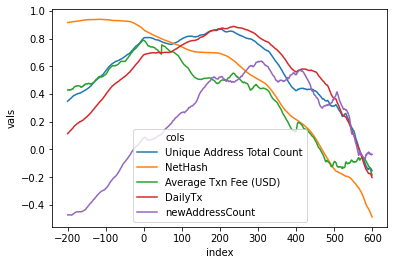

In [146]:
#  positive --> parameter on market cap
#  negative --> market cap on parameters (market cap shifts)

# def shift_(cur, c, n):
#     df = cur.copy()
#     n = -n
#     if (n>0):
#         df[c] = df[c].shift(-n)
#         return df[n:]
#         # return 0
#     elif(n<0):
#         df[c] = df[c].shift(n)
#         return df[:n]
#     else:
#         return df



def shift_(cur, c, n):
    df = cur.copy()
    if (n>0):
        df[c] = df[c].shift(-n)
        return df[:-n]
    elif(n<0):
        df[c] = df[c].shift(-n)
        return df[-n:]
    else:
        return df


arr = {}
for i in range(-200, 600):
    # cur = pd.concat([shift_(tmp, 'MarketCap', i).corr()['MarketCap'],cur], axis = 1)
    index = i
    arr[index] = shift_(tmp, 'MarketCap', index).corr()['MarketCap']

arr = pd.DataFrame.from_dict(arr).T[['Unique Address Total Count', 'NetHash', 'Average Txn Fee (USD)', 'DailyTx', 'newAddressCount']].reset_index()
# arr = pd.DataFrame.from_dict(arr).T['Average Txn Fee (USD)'].reset_index()

arr_m = arr.melt('index', var_name = 'cols', value_name = 'vals')
arr_m
sns.lineplot(data = arr_m, x = 'index', y = 'vals', hue='cols')
# arr.plot(kind = 'scatter', x='index', y=['Unique Address Total Count', 'NetHash', 'Average Txn Fee (USD)'])

In [9]:
cur.loc['Unique Address Total Count']

MarketCap    0.738628
MarketCap    0.741939
MarketCap    0.744722
MarketCap    0.747185
MarketCap    0.749642
MarketCap    0.750372
MarketCap    0.750923
MarketCap    0.751149
MarketCap    0.750777
MarketCap    0.750977
MarketCap    0.749642
Name: Unique Address Total Count, dtype: float64

In [52]:
# sns.lineplot(data = frame, x = "MarketCap", y = "NetHash", color="g")

cur = tmp.corr()['MarketCap'].copy()
# frame[['Unique Address Total Count','MarketCap']]
arr = {}
for i in range(-5, 5):
    cur = pd.concat([shift_(tmp, 'MarketCap', i*2).corr()['MarketCap'],cur], axis = 1)
    index = i*2
    arr[index] = shift_(tmp, 'MarketCap', index).corr()['MarketCap']
# cur
arr = pd.DataFrame.from_dict(arr)


In [ ]:
# 'sssd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


In [62]:
target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
target = target[target["Year"] > 2018]
# sns.scatterplot(data = target, x = "NetHash", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='Unique Address Total Count', ylabel='MarketCap'>

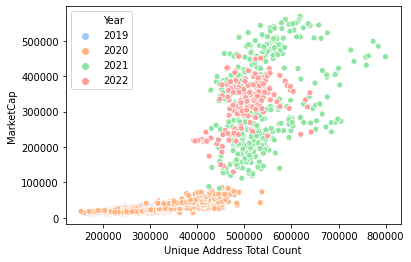

In [63]:
sns.scatterplot(data = target, x = "Unique Address Total Count", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='NetHash', ylabel='MarketCap'>

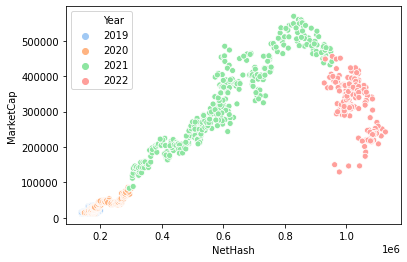

In [64]:
sns.scatterplot(data = target, x = "NetHash", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='DailyTx', ylabel='MarketCap'>

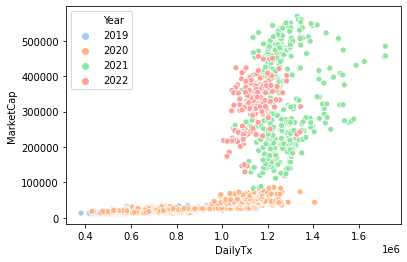

In [65]:
sns.scatterplot(data = target, x = "DailyTx", y = "MarketCap", hue="Year", palette="pastel")

In [ ]:
# UnixTimeStamp	AddressCount	Unique Address Total Count	Unique Address Receive Count	Unique Address Sent Count	Supply	MarketCap	NetHash	DailyTx	Average Txn Fee (USD)	Average Txn Fee (Ether)	newAddressCount

<AxesSubplot:xlabel='Average Txn Fee (USD)', ylabel='MarketCap'>

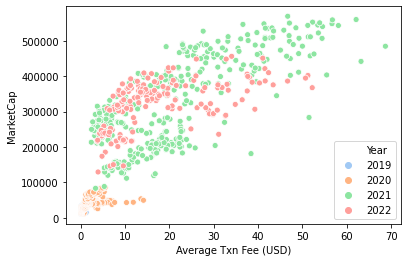

In [66]:
sns.scatterplot(data = target[target['Average Txn Fee (USD)'] < 100], x = "Average Txn Fee (USD)", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='AddressCount', ylabel='MarketCap'>

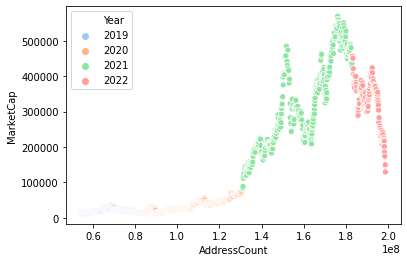

In [69]:
sns.scatterplot(data = target, x = "AddressCount", y = "MarketCap", hue="Year", palette="pastel")

In [ ]:
target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
target = target[target["Year"] > 2018]